In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import utils as utils

In [12]:
train_path = 'train.csv'
val_path = 'val.csv'

train_data = pd.read_csv(train_path)
train_data.describe()

val_data=pd.read_csv(val_path)

In [3]:
def load_glove_vectors(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Path to the GloVe file (adjust as needed)
glove_path = 'glove.6B.100d.txt'  # Adjust this path to where you've saved your GloVe data
embeddings_index = load_glove_vectors(glove_path)

In [13]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

#saving the tokenizer
with open('LSTMtokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert text to sequences and pad them
max_length = max([len(s.split()) for s in train_data['text']])
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])

X_data = pad_sequences(train_sequences, maxlen=max_length)
X_val = pad_sequences(val_sequences, maxlen=max_length)

# Encode labels
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(train_data['label'])
y_val = label_encoder.transform(val_data['label'])

#split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, random_state=42)

In [14]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
output_units = len(label_encoder.classes_)  # Number of classes

#converting encoded labels to one_hot encoding
y_train_one_hot = to_categorical(y_train, output_units)
y_test_one_hot = to_categorical(y_test, output_units)
y_val_one_hot = to_categorical(y_val, output_units)

In [15]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
def build_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
        LSTM(210, activation='tanh', recurrent_dropout=0),
        Dense(output_units, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [30]:
results = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}

#loop through each percentage
for fraction in [0.999]:
    model = build_model()  # Recreate the model for each iteration
    partial_X_train, _, partial_y_train, _ = train_test_split(X_train, y_train_one_hot,train_size=fraction, random_state=42)
    model.fit(partial_X_train, partial_y_train, epochs=4, batch_size=32, verbose=1,validation_data=(X_val, y_val_one_hot))

    # Predict on X_test
    y_pred_prob = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)
    y_test_integers = np.argmax(y_test_one_hot, axis=1)

    # Calculate metrics
    precision = precision_score(y_test_integers, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_test_integers, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_test_integers, y_pred_classes, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test_integers, y_pred_classes)

    # Store metrics
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['accuracy'].append(accuracy)

Epoch 1/4
1142/1142 [==============================] - 581s 506ms/step - loss: 1.2841 - accuracy: 0.4629 - val_loss: 1.1082 - val_accuracy: 0.5448
Epoch 2/4
 570/1142 [=============>................] - ETA: 4:19 - loss: 1.0560 - accuracy: 0.5771

KeyboardInterrupt: 

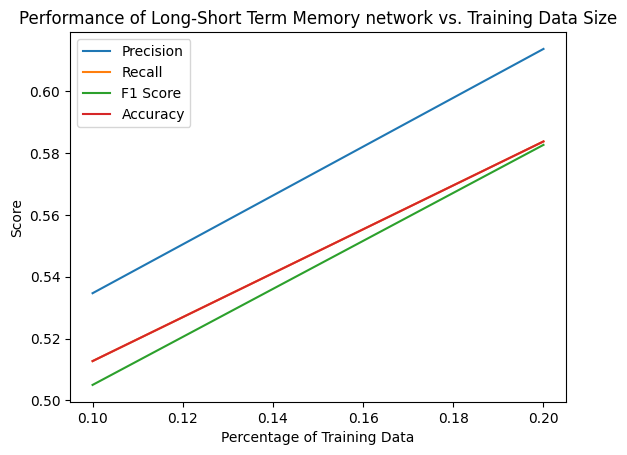

In [ ]:
utils.create_graph([0.1, 0.2], results, 'Long-Short Term Memory network', 'LSTM.png')

In [ ]:
model.save('LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
print(results)

{'precision': [], 'recall': [], 'f1': [], 'accuracy': []}
